# Load and Visualize Data

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [24]:
from keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, AlphaDropout, GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [13]:
x_data = np.load('X_train.npy')
y_data = np.load('Y_train.npy')

In [14]:
def get_description(label):
    options = ['Normal',
               'Begnign Calcification',
               'Malignant Calcification',
               'Benign Mass',
               'Malignant Mass']
    
    return options[np.argmax(label)]

In [15]:
def get_binary_class(label):
    malignant_vector = [0,0,1,0,1]
    is_malignant = np.sum(label*malignant_vector)
    return np.array([1-is_malignant, is_malignant])

In [16]:
x_data.shape, x_data.dtype, x_data.min(), x_data.max()

((10713, 256, 256), dtype('float64'), 0.0, 255.0)

In [17]:
y_data.shape, y_data.dtype, y_data.min(), y_data.max()

((10713, 5), dtype('float64'), 0.0, 1.0)

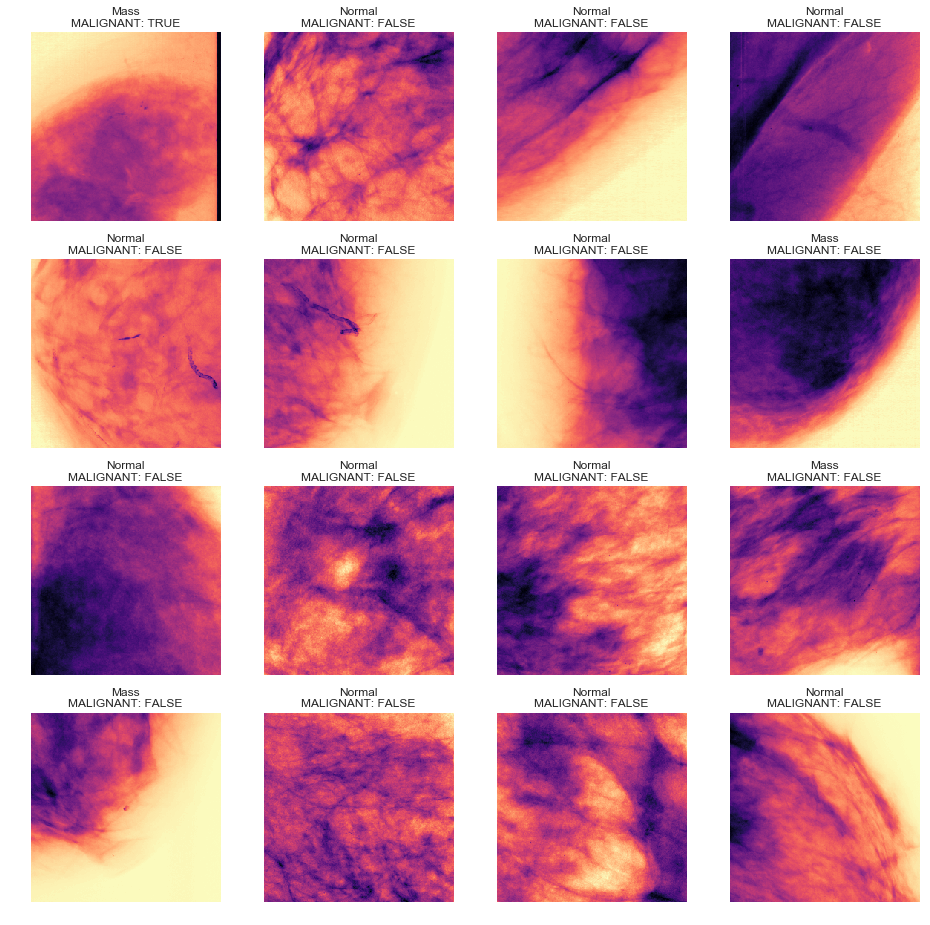

In [18]:
fig = plt.figure(figsize=(16,16))
for i in range(16):
    idx = np.random.randint(0,x_data.shape[0])
    ax = fig.add_subplot(4,4,i+1)
    plt.imshow(255-x_data[idx], cmap='magma')
    plt.title(get_description(y_data[idx]).split()[-1] + '\nMALIGNANT: ' + str(bool(get_binary_class(y_data[idx])[1])).upper())
    plt.axis('off');

In [19]:
# convert labels to binary
y_data_binary = np.apply_along_axis(get_binary_class, axis=1, arr=y_data)
y_data_binary.shape

(10713, 2)

In [11]:
# make 3-chanel images. wasteful of memory, but the pre-built models want it.
x_data_3chan = np.empty(shape=(*x_data.shape,3))
for i in tqdm(range(x_data.shape[0])):
    x_data_3chan[i,...,0] = x_data[i]
    x_data_3chan[i,...,1] = x_data[i]    
    x_data_3chan[i,...,2] = x_data[i]

100%|██████████| 10713/10713 [00:14<00:00, 729.25it/s]


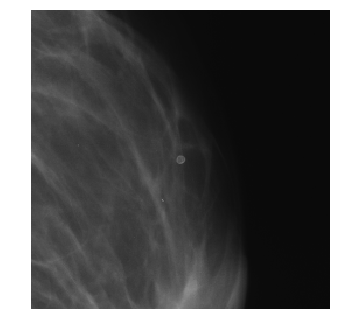

In [12]:
plt.imshow(x_data_3chan[42].astype(np.uint8))
plt.axis('off');

In [20]:
from sklearn.cross_validation import train_test_split

/Users/davidloving/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_data_3chan, y_data_binary, random_state=42)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8034, 256, 256, 3), (8034, 2), (2679, 256, 256, 3), (2679, 2))

In [23]:
# classes are majorly imbalanced so we want to use class weights when training

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.arange(2), np.argmax(y_train, axis=1))
class_weights

array([0.60799152, 2.8149965 ])

# InceptionResNetV2

In [25]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [26]:
#
# preprocess_input MUTATES the input array!
#

x_train_irv2 = preprocess_input(x_train.copy())
x_test_irv2 = preprocess_input(x_test.copy())

In [27]:
from keras.optimizers import SGD

In [28]:
# instantiate model without pre-trained weights
inresv2_model_b = InceptionResNetV2(include_top=True, weights=None, classes=2)

In [29]:
inresv2_model_b.compile(optimizer=SGD(lr=0.01), loss='categorical_crossentropy', metrics=['acc'])

In [75]:
checkpoint = ModelCheckpoint('checkpoint_bbbb.hdf5', save_best_only=True)

history = inresv2_model_b.fit(x=x_train_nasnet,
                             y=y_train,
                             epochs=15,
                             batch_size=32,
                             validation_data=(x_test_nasnet, y_test),
                             class_weight=class_weights,
                             callbacks=[checkpoint])

Train on 8034 samples, validate on 2679 samples
Epoch 1/15
8034/8034 [==============================] - 321s 40ms/step - loss: 0.3035 - acc: 0.8703 - val_loss: 0.3814 - val_acc: 0.8391
Epoch 2/15
8034/8034 [==============================] - 279s 35ms/step - loss: 0.3029 - acc: 0.8729 - val_loss: 0.3921 - val_acc: 0.8425
Epoch 3/15
8034/8034 [==============================] - 280s 35ms/step - loss: 0.2988 - acc: 0.8712 - val_loss: 0.3870 - val_acc: 0.8410
Epoch 4/15
8034/8034 [==============================] - 280s 35ms/step - loss: 0.3046 - acc: 0.8678 - val_loss: 0.3850 - val_acc: 0.8365
Epoch 5/15
8034/8034 [==============================] - 280s 35ms/step - loss: 0.3016 - acc: 0.8733 - val_loss: 0.3833 - val_acc: 0.8402
Epoch 6/15
8034/8034 [==============================] - 280s 35ms/step - loss: 0.3019 - acc: 0.8697 - val_loss: 0.3842 - val_acc: 0.8395
Epoch 7/15
8034/8034 [==============================] - 280s 35ms/step - loss: 0.3013 - acc: 0.8694 - val_loss: 0.3864 - val_acc: 

In [30]:
inresv2_model_b.load_weights('checkpoint_bbbb.hdf5')  # that's a lot of b's.

In [31]:
preds =  inresv2_model_b.predict(x_test_irv2, batch_size=64, verbose=True)

2679/2679 [==============================] - 30s 11ms/step


# Evaluate

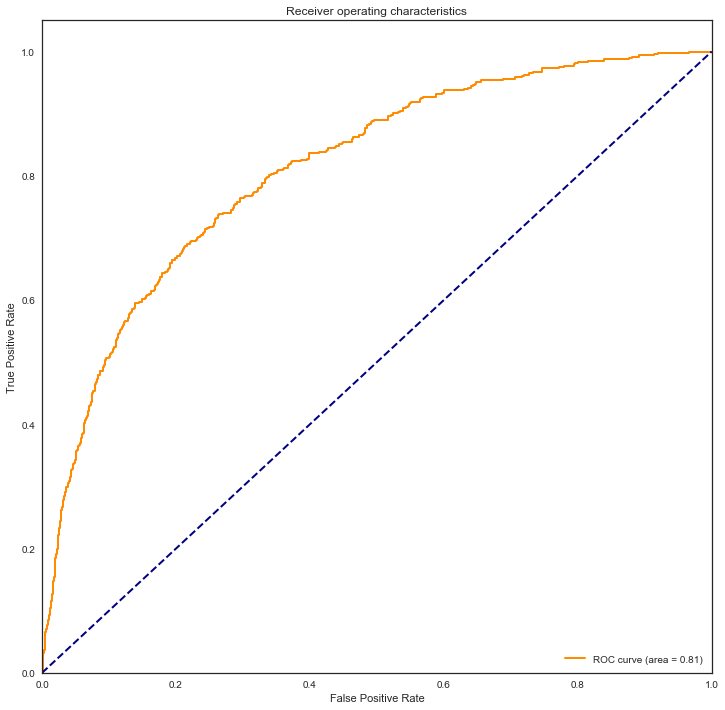

In [41]:
from sklearn.metrics import roc_curve, auc

# adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr, tpr, _ = roc_curve(y_test[:,1], preds[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,12))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
sns.set_style('white')
plt.show()

## Prepare features for use with Bayesian classifier

In [30]:
# Use the output of the convolutional layers as features to the bayesian model
inresv2_model_b.layers[-2].name

'avg_pool'

In [49]:
inresv2_feature_model = Model(inresv2_model_b.input, inresv2_model_b.layers[-2].output)

In [32]:
inresv2_feats_train = inresv2_feature_model.predict(x_train_irv2, verbose=1)
inresv2_feats_test = inresv2_feature_model.predict(x_test_irv2, verbose=1)

2679/2679 [==============================] - 29s 11ms/step


In [33]:
np.save('feats_train.npy', inresv2_feats_train)
np.save('feats_test.npy', inresv2_feats_test)

In [22]:
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [23]:
np.save('y_all.npy', y_data_binary)

In [35]:
x_data_all = preprocess_input(x_data_3chan.copy())

In [50]:
inresv2_feats_all = inresv2_feature_model.predict(x_data_all, verbose=1)
np.save('feats_all.npy', inresv2_feats_all)

10713/10713 [==============================] - 140s 13ms/step
